In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy as np

import rfm

import ntk

import torch.nn as nn
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms

`eigenpro2` is not installed...
Using `torch.linalg.solve` for training the kernel model

          and may cause an `Out-of-Memory` error
`eigenpro2` is a more scalable solver. To use, pass `method="eigenpro"` to `model.fit()`
To install `eigenpro2` visit https://github.com/EigenPro/EigenPro-pytorch/tree/pytorch/
Importing


In [48]:
## variables
os.environ['DATA_PATH'] = "/scratch/bbjr/dbeaglehole/"
dataset = 'mnist'

In [59]:
def one_hot_data(dataset, num_classes, num_samples):
    Xs = []
    ys = []

    for ix in range(min(len(dataset),num_samples)):
        X,y = dataset[ix]
        Xs.append(X)

        ohe_y = torch.zeros(num_classes)
        ohe_y[y] = 1
        ys.append(ohe_y)

    return torch.stack(Xs), torch.stack(ys)

def get_binary(dataset, classes):
    c1, c2 = classes
    
    binary_dataset = []
    for ix in tqdm(range(len(dataset))):
        X,y = dataset[ix]
        
        if y==c1:
            binary_dataset.append((X,0))
        elif y==c2:
            binary_dataset.append((X,1))

    return binary_dataset

if dataset=='mnist':
    transform = transforms.Compose(
        [
            transforms.Resize((28, 28)),
            transforms.ToTensor(),
        ]
    )

    path = os.environ["DATA_PATH"] + "MNIST/"
    trainset = torchvision.datasets.MNIST(root=path,
                                        train = True,
                                        transform=transform,
                                        download=True)
    testset = torchvision.datasets.MNIST(root=path,
                                        train = False,
                                        transform=transform,
                                        download=True)
elif dataset=='cifar':
    transform = transforms.Compose(
        [
            transforms.Resize((32, 32)),
            transforms.ToTensor(),
        ]
    )

    path = os.environ["DATA_PATH"] + "cifar10/"

    trainset = torchvision.datasets.CIFAR10(root=path,
                                            train=True,
                                            transform=transform,
                                            download=True)
    testset = torchvision.datasets.CIFAR10(root=path,
                                           train=False,
                                           transform=transform,
                                           download=True)

NUM_CLASSES = 10

# NUM_CLASSES = 2
# class1 = 3
# class2 = 5
# trainset = get_binary(trainset, classes=(class1, class2))
# testset = get_binary(testset, classes=(class1, class2))

n=2048
train_X, train_y = one_hot_data(trainset, NUM_CLASSES, num_samples=n)
test_X, test_y = one_hot_data(testset, NUM_CLASSES, num_samples=n)

In [60]:
train_X = train_X.cuda()
train_y = train_y.cuda()
test_X = test_X.cuda()
test_y = test_y.cuda()

In [61]:
## reorder data
newXs = []
newYs = []
for c in range(NUM_CLASSES):
    class1_idx = train_y[:,c] == 1
    newYs.append(train_y[class1_idx])
    newXs.append(train_X[class1_idx])

train_X = torch.concat(newXs,dim=0)
train_y = torch.concat(newYs,dim=0)
print(train_X.shape, train_y.shape)

torch.Size([2048, 1, 28, 28]) torch.Size([2048, 10])


In [ ]:
train_y = train_y[:,0].unsqueeze(1)
test_y = test_y[:,0].unsqueeze(1)

In [55]:
def matrix_sqrt(M):
    S, V = torch.linalg.eigh(M)
    S[S<0] = 0
    S = torch.diag(S**0.5)
    return V @ S @ V.T
    
class Activation(nn.Module):
    def __init__(self):
        super(Activation, self).__init__()
    def forward(self, x):
        return nn.ReLU()(x)
    
def sample_feats(M, d, k):
    weight_fn = nn.Linear(d, k, bias=False).to(M.device)
    weight_fn.weight = nn.Parameter(weight_fn.weight@M, requires_grad=False)
    return nn.Sequential(weight_fn, 
                      Activation()
                     )

In [56]:
import utils 
import ntk
from functorch import jacrev, vmap

def get_grads(alphas, train_X, Xs, M, ntk_depth=1):
    
    M_is_passed = M is not None
    sqrtM = None
    if M_is_passed:
        sqrtM = utils.matrix_sqrt(M)
    
    def get_solo_grads(sol, X, x):
        if M_is_passed:
            X_M = X@sqrtM
        else:
            X_M = X
            
        print("X",X.shape, 'x', x.shape, 'sol', sol.shape)
    

        def egop_fn(z):
            if M_is_passed:
                z_ = z@sqrtM
            else:
                z_ = z
            K = ntk.ntk_relu(z_, X_M, M=None, depth=ntk_depth)[1]
            # print("Inside egop X, z", X_M.shape, z.shape)
            # print("Inside egop K", K.shape)
            return (K@sol).squeeze()
        grads = vmap(jacrev(egop_fn))(x.unsqueeze(1)).squeeze()
        grads = torch.nan_to_num(grads)
        return grads 

    n, d = train_X.shape
    s = len(Xs)
    
    chunk = 1000
    train_batches = torch.split(torch.arange(n), chunk)

    egop = 0
    G = 0
    for btrain in train_batches:
        G += get_solo_grads(alphas[btrain,:], train_X[btrain], Xs)
    G = G.reshape(-1, d)
    egop += G.T @ G/s

    return egop

In [57]:
def ntk_rfm(train_X, train_y, test_X, test_y, iters, reg, ntk_depth):
    n, d = train_X.shape
    M = None
    for t in range(iters):
        Ktrain = ntk.ntk_relu(train_X, depth=ntk_depth, M=M)[1]
        Ktest = ntk.ntk_relu(test_X, train_X, depth=ntk_depth, M=M)[1]
        
        # print("Centering kernels")
        # a = torch.zeros((1,d)).to(train_X.device)
        # b = torch.zeros((1,d)).to(train_X.device)
        # a[0,0] = 1
        # b[0,1] = 1     
        # alpha = ntk.ntk_relu(a,b,depth=ntk_depth)[1].item()
        # alpha /= 1
        # Ktrain -= alpha*torch.ones(Ktrain.shape).to(Ktrain.device)
        # Ktest -= alpha*torch.ones(Ktest.shape).to(Ktest.device)
        
        alphas = torch.linalg.solve(reg*torch.eye(n).to(Ktrain.device) + Ktrain, train_y)
        ypred = Ktest@alphas
        
        acc = torch.mean(1.0*(torch.argmax(ypred,dim=1) == torch.argmax(test_y,dim=1))) * 100
        mse = torch.mean(torch.sum((ypred - test_y)**2,axis=1))
        
        print(f'Round {t} accuracy: {acc}%')
        print(f'Round {t} MSE: {mse}')
        print()
            
        M = get_grads(alphas, train_X, train_X, M)
        
    return M

In [58]:
%%capture

DEPTH = 8
ITERS = 1
WIDTH = 2048
# KERNEL='ntk'
KERNEL='laplace'
# KERNEL='gaussian'
NTK_DEPTH=1

train_X_deep = train_X.reshape(len(train_X),-1) 
test_X_deep = test_X.reshape(len(test_X),-1)

XXs = []
for dep in range(DEPTH):
    print(f'Depth {dep} of DeepRFM')
    
    train_X_deep -= train_X_deep.mean(dim=0).unsqueeze(0)
    
    train_X_deep /= train_X_deep.norm(dim=-1).unsqueeze(1)
    test_X_deep /= test_X_deep.norm(dim=-1).unsqueeze(1)
    
    
    XX = (train_X_deep@train_X_deep.T).cpu()
    XXs.append(XX)
    
    # plt.imshow(XX)
    # plt.colorbar()
    # plt.savefig(f'figures/dataset_{dataset}_layer_{dep}_inner_product_matrix_deepRFM',format='pdf')
    # plt.close()
    
    if KERNEL == 'laplace':
        model = rfm.LaplaceRFM(bandwidth=2., device="cuda")
        model.fit(
            (train_X_deep, train_y), 
            (test_X_deep, test_y), 
            loader=False, 
            iters=ITERS,
            classif=True,
            reg=0.
        )
        M = model.M
    if KERNEL == 'gaussian':
        model = rfm.GaussRFM(bandwidth=2., device="cuda")
        model.fit(
            (train_X_deep, train_y), 
            (test_X_deep, test_y), 
            loader=False, 
            iters=ITERS,
            classif=True,
            reg=0.
        )
        M = model.M
    elif KERNEL == 'ntk':
        M = ntk_rfm(
            train_X_deep, train_y, 
            test_X_deep, test_y,
            iters=ITERS,
            reg=0.,
            ntk_depth=NTK_DEPTH
        )
        
    _, d = train_X_deep.shape

    feature_fn = sample_feats(matrix_sqrt(M), d, WIDTH).cuda()
    train_X_deep = feature_fn(train_X_deep)
    test_X_deep = feature_fn(test_X_deep)
    print('\n\n')

RuntimeError: Detected the following values in `target`: tensor([-1.,  1.], device='cuda:0') but expected only the following values [0, 1].

In [47]:
def scale(A):
    return (A - A.min())/(A.max() - A.min())

IndexError: list index out of range

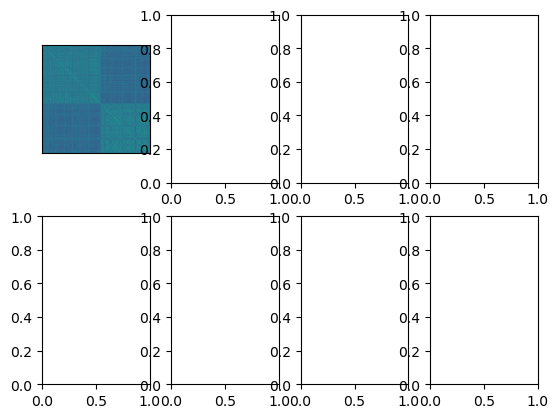

In [39]:
PLOTS_PER_ROW=4
NUM_ROWS = DEPTH//PLOTS_PER_ROW
fig, axes = plt.subplots(NUM_ROWS, PLOTS_PER_ROW)

for row in range(NUM_ROWS):
    for col in range(PLOTS_PER_ROW):
        ax = axes[row][col]
        
        idx = int(row * PLOTS_PER_ROW) + col
        XX = XXs[idx]
        ax.imshow(scale(XX))
        ax.set_xticks([])
        ax.set_yticks([])

In [97]:
S, U = torch.linalg.eigh(M)

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

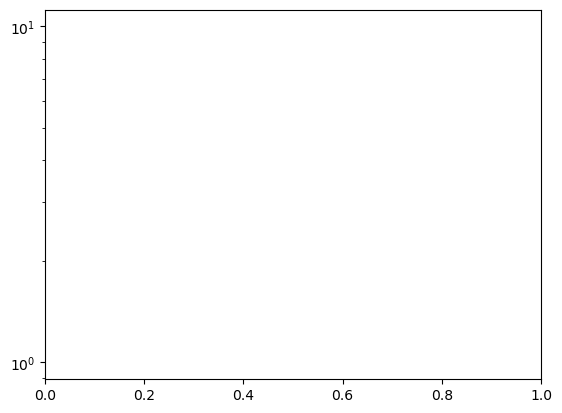

In [12]:
plt.semilogy(S)
plt.xlabel(r'$k$')
plt.ylabel(r'$\lambda_k$')
plt.title('Spectral decay of AGOP')
plt.show()

In [ ]:
S[-20:]

In [ ]:
u0 = U[:,-1]
u1 = U[:,-2]

In [ ]:
o0 = train_X_deep@u0
o1 = train_X_deep@u1

In [ ]:
X0 = train_X_deep @ u0.unsqueeze(1) @ u0.unsqueeze(0)
X1 = train_X_deep @ u1.unsqueeze(1) @ u1.unsqueeze(0)

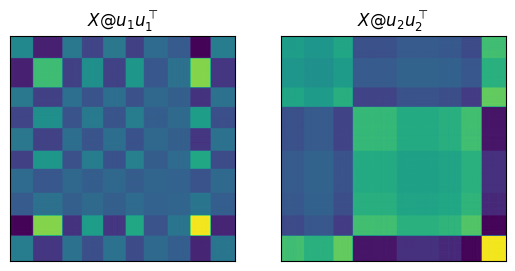

In [17]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(X0@X0.T)
ax2.imshow(X1@X1.T)

ax1.set_title(r'$X @ u_1 u_1^\top$')
ax2.set_title(r'$X @ u_2 u_2^\top$')

ax1.set_xticks([])
ax2.set_xticks([])
ax1.set_yticks([])
ax2.set_yticks([])

plt.show()